In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import collections
import math
import os
import random
import zipfile

import numpy as np
from six.moves import urllib
from six.moves import xrange  # pylint: disable=redefined-builtin
import tensorflow as tf

# Step 1: Download the data.
url = 'http://mattmahoney.net/dc/'

def maybe_download(filename, expected_bytes):
  """Download a file if not present, and make sure it's the right size."""
  if not os.path.exists(filename):
    filename, _ = urllib.request.urlretrieve(url + filename, filename)
  statinfo = os.stat(filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified', filename)
  else:
    print(statinfo.st_size)
    raise Exception(
        'Failed to verify ' + filename + '. Can you get to it with a browser?')
  return filename

filename = maybe_download('text8.zip', 31344016)


# Read the data into a list of strings.
def read_data(filename):
  """Extract the first file enclosed in a zip file as a list of words"""
  with zipfile.ZipFile(filename) as f:
    data = tf.compat.as_str(f.read(f.namelist()[0])).split()
  return data

words = read_data(filename)
print('Data size', len(words))

Found and verified text8.zip
Data size 17005207


Load the dataset, a period of articles containing 17 million words.

In [2]:
# Step 2-1: Build the dictionary and replace rare words with UNK token.
vocabulary_size = 50000

def build_dataset(words):
  count = [['UNK', -1]]
  count.extend(collections.Counter(words).most_common(vocabulary_size - 1))
  dictionary = dict()
  for word, _ in count:
    dictionary[word] = len(dictionary)
  data = list()
  unk_count = 0
  for word in words:
    if word in dictionary:
      index = dictionary[word]
    else:
      index = 0  # dictionary['UNK']
      unk_count += 1
    data.append(index)
  count[0][1] = unk_count
  reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys()))
  return data, count, dictionary, reverse_dictionary

In [3]:
data, count, dictionary, reverse_dictionary = build_dataset(words)
del words  # Hint to reduce memory.
print(len(count))
print('Most common words (+UNK)', count[:5])
print('Sample data', data[:10], [reverse_dictionary[i] for i in data[:10]])

50000
Most common words (+UNK) [['UNK', 418391], ('the', 1061396), ('of', 593677), ('and', 416629), ('one', 411764)]
Sample data [5239, 3084, 12, 6, 195, 2, 3137, 46, 59, 156] ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against']


data: the rank of words in terms of frequency in appeared order

count: the K-V pairs of words-appearing times from the most frequent words (besides UNK)

dictionary: K-V pairs of words-rank

reverse_dictionary: K-V pairs of rank-words

In [6]:
data_index = 0


# Step 3: Function to generate a training batch for the CBOW model.
def generate_cbow_batch(batch_size, num_skips, skip_window):
  global data_index
  assert batch_size % num_skips == 0
  assert num_skips <= 2 * skip_window
  #这里batch要作为一个2d的array，每一行代表一个词所对应的环境
  batch = np.ndarray(shape=(batch_size, num_skips), dtype=np.int32)
  labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
  span = 2 * skip_window + 1 # [ skip_window target skip_window ]
  buffer = collections.deque(maxlen=span)
  for _ in range(span):
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
  for i in range(batch_size):
    target = skip_window  # target label at the center of the buffer
    targets_to_avoid = [ skip_window ]
    #定义一个temp的batch array作为暂时储存环境的array,在储存完毕后输出
    batch_temp = np.ndarray(shape=(num_skips), dtype=np.int32)
    for j in range(num_skips):
      while target in targets_to_avoid:
        target = random.randint(0, span - 1)
      targets_to_avoid.append(target)
      batch_temp[j] = buffer[target]
    batch[i] = batch_temp
    labels[i,0] = buffer[skip_window]
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
  return batch, labels

"Anarchism originated as a term of"

In [8]:

# Step 4: Build and train a skip-gram model.

batch_size = 128
embedding_size = 128  # Dimension of the embedding vector.
skip_window = 1       # How many words to consider left and right.
num_skips = 2         # How many times to reuse an input to generate a label.

# We pick a random validation set to sample nearest neighbors. Here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent.
valid_size = 16     # Random set of words to evaluate similarity on.
valid_window = 100  # Only pick dev samples in the head of the distribution.
valid_examples = np.random.choice(valid_window, valid_size, replace=False)
num_sampled = 64    # Number of negative examples to sample.

graph = tf.Graph()
 
with graph.as_default():
   
  # Input data.
   
  #变更1:
  #---------------------------------------------------------------------------------------------------------------
  # 这里的输入对应的是skip-gram，input大小是batch_size X 1
  #train_inputs = tf.placeholder(tf.int32, shape=[batch_size])
  #这里由于我们的输入对于每个词而言有一个context的输入，我们的input的大小为batch_size X context
  train_inputs = tf.placeholder(tf.int32,shape=[batch_size, skip_window * 2])
  #---------------------------------------------------------------------------------------------------------------
 
  train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
  valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
 
  # Ops and variables pinned to the CPU because of missing GPU implementation
  with tf.device('/cpu:0'):
    # Look up embeddings for inputs.
    embeddings = tf.Variable(
        tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
    # Embedding size is calculated as shape(train_inputs) + shape(embeddings)[1:]
    embed = tf.nn.embedding_lookup(embeddings, train_inputs)
     
    #变更2:
    #---------------------------------------------------------------------------------------------------------------
    #这里增加的就是首先加权embed变量，然后平均。注意这个reduce_sum里的第二个para设为1
    #原因在于假设我们的batch_size是200, window_size是4, 然后词向量size是200, 我们会得到
    #一个大小为200X4X200的张量，因为我们一次运行200个例子，每个例子有4个环境词，然后
    #每个词的大小为200维。但是，别忘了我们需要对这些输入加权，我们所期待的其实是把张量
    #里4的那个维度加权起来，于是，我们需要把这个para设为1.设为0加权的是例子的200维，3加权
    #的是每个词向量自身。
    reduced_embed = tf.div(tf.reduce_sum(embed, 1), skip_window*2)
    #---------------------------------------------------------------------------------------------------------------
 
    # Construct the variables for the NCE loss
    nce_weights = tf.Variable(
        tf.truncated_normal([vocabulary_size, embedding_size],
                            stddev=1.0 / math.sqrt(embedding_size)))
    nce_biases = tf.Variable(tf.zeros([vocabulary_size]))
 
  # Compute the average NCE loss for the batch.
  # tf.nce_loss automatically draws a new sample of the negative labels each
  # time we evaluate the loss.
  loss = tf.reduce_mean(
      tf.nn.nce_loss(nce_weights, nce_biases, reduced_embed, train_labels,
                     num_sampled, vocabulary_size))
 
  # Construct the SGD optimizer using a learning rate of 1.0.
  optimizer = tf.train.GradientDescentOptimizer(1.0).minimize(loss)
 
  # Compute the cosine similarity between minibatch examples and all embeddings.
  norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
  normalized_embeddings = embeddings / norm
  valid_embeddings = tf.nn.embedding_lookup(
      normalized_embeddings, valid_dataset)
  similarity = tf.matmul(
      valid_embeddings, normalized_embeddings, transpose_b=True)
 
  # Add variable initializer.
  init = tf.initialize_all_variables()
 
# Step 5: Begin training.
num_steps = 100001
 
with tf.Session(graph=graph) as session:
  # We must initialize all variables before we use them.
  init.run()
  print("Initialized")
 
  average_loss = 0
  for step in xrange(num_steps):
    #变更3:
    #---------------------------------------------------------------------------------------------------------------
    #在这里把generate_batch或者generate_skipgram_batch修改为generate_cbow_batch就可以了
    batch_inputs, batch_labels = generate_cbow_batch(
        batch_size, num_skips, skip_window)
    #---------------------------------------------------------------------------------------------------------------
 
    feed_dict = {train_inputs : batch_inputs, train_labels : batch_labels}
 
    # We perform one update step by evaluating the optimizer op (including it
    # in the list of returned values for session.run()
    _, loss_val = session.run([optimizer, loss], feed_dict=feed_dict)
    average_loss += loss_val

    if step % 10000 == 0:
      if step > 0:
        average_loss /= 10000
      # The average loss is an estimate of the loss over the last 2000 batches.
      print("Average loss at step ", step, ": ", average_loss)
      average_loss = 0

    # Note that this is expensive (~20% slowdown if computed every 500 steps)
    if step % 20000 == 0:
      sim = similarity.eval()
      for i in xrange(valid_size):
        valid_word = reverse_dictionary[valid_examples[i]]
        top_k = 8 # number of nearest neighbors
        nearest = (-sim[i, :]).argsort()[1:top_k+1]
        log_str = "Nearest to %s:" % valid_word
        for k in xrange(top_k):
          close_word = reverse_dictionary[nearest[k]]
          log_str = "%s %s," % (log_str, close_word)
        print(log_str)
  final_embeddings = normalized_embeddings.eval()


Initialized
Average loss at step  0 :  280.716552734
Nearest to over: august, presided, organize, stance, impressions, hbc, suspend, shah,
Nearest to united: sister, betrays, beggars, phoneme, pradesh, exams, wheatstone, worship,
Nearest to have: rectifier, nit, gil, ccg, hennessy, hampton, breath, loading,
Nearest to b: leap, izmir, microtubules, obsessive, corel, evaporating, azo, puzzles,
Nearest to than: clifton, picatinny, prominence, aroused, equinox, distances, glick, guido,
Nearest to while: universiteit, scrip, havas, prince, chennai, kodiak, tipper, afrique,
Nearest to but: macleod, msm, rett, uplifted, impairments, infallible, richey, arnulf,
Nearest to it: ifr, reliability, java, terre, moli, kohoutek, exec, rterbuch,
Nearest to would: magnetometer, iga, alicante, unam, tome, borges, articulated, out,
Nearest to states: witold, resistors, jos, homework, randal, flown, centimeters, diverting,
Nearest to has: kalimantan, chilean, esteem, commissioning, maternal, convexity, pi

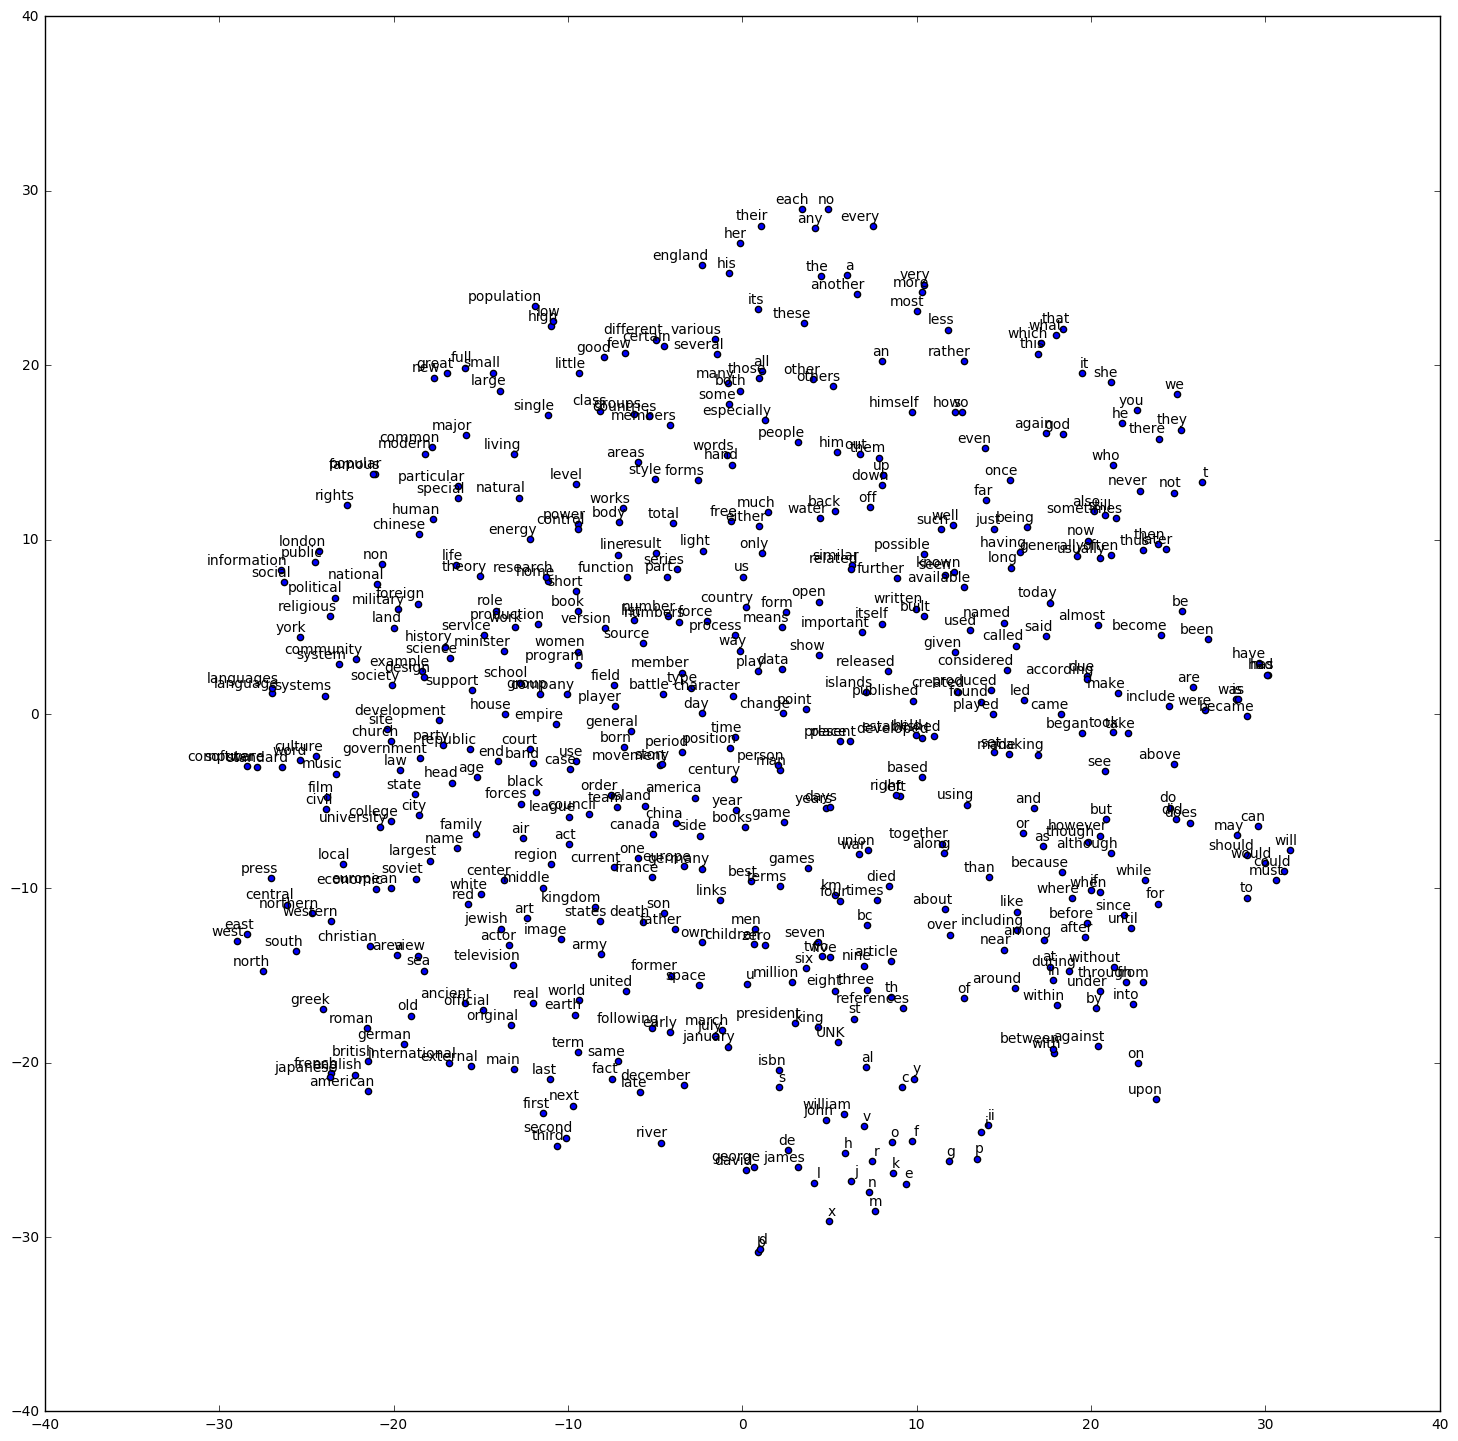

In [9]:
%matplotlib inline

# Step 6: Visualize the embeddings.

def plot_with_labels(low_dim_embs, labels, filename='tsne.png'):
  assert low_dim_embs.shape[0] >= len(labels), "More labels than embeddings"
  plt.figure(figsize=(18, 18))  #in inches
  for i, label in enumerate(labels):
    x, y = low_dim_embs[i,:]
    plt.scatter(x, y)
    plt.annotate(label,
                 xy=(x, y),
                 xytext=(5, 2),
                 textcoords='offset points',
                 ha='right',
                 va='bottom')

  plt.savefig(filename)

try:
  from sklearn.manifold import TSNE
  import matplotlib.pyplot as plt

  tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
  plot_only = 500
  low_dim_embs = tsne.fit_transform(final_embeddings[:plot_only,:])
  labels = [reverse_dictionary[i] for i in xrange(plot_only)]
  plot_with_labels(low_dim_embs, labels)

except ImportError:
  print("Please install sklearn, matplotlib, and scipy to visualize embeddings.")